In [26]:
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import time
import nltk
from nltk.corpus import stopwords

In [2]:
browser = webdriver.Chrome('./chromedriver')
url = 'https://www.youtube.com/watch?v=npnH0_natfs'
browser.get(url)

/var/folders/zc/1dftl_rj0b55snyh5w747lv80000gn/T/ipykernel_74090/3573404249.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome('./chromedriver')


In [3]:
# Scroll down the page to see all the comments
while True:
    scroll_height = 2000
    document_height_before = browser.execute_script('return document.documentElement.scrollHeight')
    browser.execute_script(f'window.scrollTo(0, {document_height_before + scroll_height});')
    time.sleep(1.8)
    document_height_after = browser.execute_script('return document.documentElement.scrollHeight')
    if document_height_after == document_height_before:
        break  

In [4]:
selector = '#content'
comms = browser.find_elements_by_css_selector(selector)

/var/folders/zc/1dftl_rj0b55snyh5w747lv80000gn/T/ipykernel_74090/2083964583.py:2: DeprecationWarning: find_elements_by_css_selector is deprecated. Please use find_elements(by=By.CSS_SELECTOR, value=css_selector) instead
  comms = browser.find_elements_by_css_selector(selector)


In [6]:
comments_lst = [comment.text for comment in comms]

In [8]:
train_df = pd.DataFrame({'comment':comments_lst})

In [10]:
train_df = train_df[train_df['comment'] != '']

In [12]:
train_df.drop([0], axis = 0, inplace = True)

/Users/junhoeum/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
train_df1 = train_df.copy()

In [18]:
# pre-process data
# drop all null values
train_df1.dropna(inplace = True)
# drop all duplicates
train_df1.drop_duplicates(subset = ['comment'], inplace = True)

In [23]:
# Count all uppercase words
# Negativity & Anger Analysis
train_df1['upper_count'] = train_df1['comment'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [25]:
# Removing punctuation
train_df1['comment'] = train_df1['comment'].str.replace('[^\w\s]', '')

/var/folders/zc/1dftl_rj0b55snyh5w747lv80000gn/T/ipykernel_74090/1022500390.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df1['comment'] = train_df1['comment'].str.replace('[^\w\s]', '')


In [27]:
# Remove stopwords
stop = stopwords.words()
train_df1['comment'] = train_df1['comment'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

In [32]:
# Look for frequently used word
freq = pd.Series(' '.join(train_df['comment']).split(' ')).value_counts()[:10]
# Remove top 10 freq used words since it doesn't contain any meaning
train_df1['comment'] = train_df1['comment'].apply(lambda x: ' '.join(x for x in x.split(' ') if x not in freq))

In [35]:
# Look for rarely used words
rare = pd.Series(' '.join(train_df['comment']).split(' ')).value_counts()[-10:]
train_df1['comment'] = train_df['comment'].apply(lambda x: ' '.join(x for x in x.split() if x not in rare))


In [37]:
# Lowercasing the comments
train_df1['comment'] = train_df1['comment'].apply(lambda x: x.lower())

In [38]:
train_df1

,comment,upper_count
7,cbs miami's carey codd reports on the latest c...,1
8,love how school's don't take real solid action...,0
9,damn he really is the quiet kid.,0
10,i feel for his family. imagine waking up to yo...,2
11,why is nobody talking about the guy who saved ...,0
...,...,...
1963,dont force the killer out of someone and you w...,0
1964,if the guy on death row has life insurance and...,0
1965,what the hell ddt oes he need a attorney for? ...,1
1966,ha. what he supposed to say “i shot a bunch of...,1


In [39]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/junhoeum/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [40]:
lemmatizer = WordNetLemmatizer()

def lemmatizer_pos(sentence):
    sentence = sentence.split()
    words_and_tags = nltk.pos_tag(sentence)
    lemmatized_lst = []
    for word, tag in words_and_tags:
        lemma = lemmatizer.lemmatize(word, pos = get_wordnet_pos(tag))
        lemmatized_lst.append(lemma)
    return ' '.join(lemmatized_lst)

In [42]:
train_df1['lemmatized'] = train_df1['comment'].apply(lambda x: lemmatizer_pos(x))

In [45]:
from textblob import TextBlob
def polarity_score(sentence):
    res = TextBlob(sentence)
    return res.sentiment.polarity
train_df1['polarity_score'] = train_df1['comment'].apply(lambda x: polarity_score(x))
train_df1['label'] = train_df1['polarity_score'].apply(lambda x: 1 if x > 0 else 0)

<AxesSubplot:>

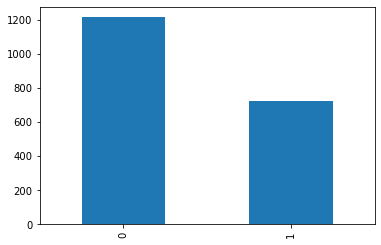

In [47]:
train_df1['label'].value_counts().plot(kind = 'bar')

In [48]:
train_df1.to_csv('Shooting_Suspect.csv')